In [14]:
# Import dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [15]:
# Set some display options
pd.set_option('max_colwidth', 400)

In [16]:
# Read the data into a Pandas DataFrame
df = pd.read_csv('resources/play_by_play_2024_cleaned.csv')
df.head()

,play_id,game_id,posteam,defteam,side_of_field,yardline_100,down,yrdln,ydstogo,play_type,...,return_touchdown,field_goal_attempt,fumble,passing_yards,receiving_yards,rushing_yards,fixed_drive_result,drive_time_of_possession,drive_end_transition,qb_epa
0,1,2024_01_ARI_BUF,NaN,NaN,NaN,NaN,NaN,BUF 35,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Touchdown,NaN,NaN,0.000000
1,40,2024_01_ARI_BUF,ARI,BUF,BUF,35.0,NaN,BUF 35,0,kickoff,...,0.0,0.0,0.0,NaN,NaN,NaN,Touchdown,7:13,TOUCHDOWN,0.257819
2,61,2024_01_ARI_BUF,ARI,BUF,ARI,70.0,1.0,ARI 30,10,run,...,0.0,0.0,0.0,NaN,NaN,3.0,Touchdown,7:13,TOUCHDOWN,-0.200602
3,83,2024_01_ARI_BUF,ARI,BUF,ARI,67.0,2.0,ARI 33,7,pass,...,0.0,0.0,0.0,22.0,22.0,NaN,Touchdown,7:13,TOUCHDOWN,2.028874
4,108,2024_01_ARI_BUF,ARI,BUF,BUF,45.0,1.0,BUF 45,10,pass,...,0.0,0.0,0.0,9.0,9.0,NaN,Touchdown,7:13,TOUCHDOWN,0.754242


### Question #1
---
**Ruby Bhatia**
- How do teams perform offensively and defensively in NFL Week 1 games?


### Question #2
----
**Nathan Roller**
- What are tendencies for teams in specific down and distance situations? 


### Question #3 
---
**Justin Nolan**
- How do different team statistics correlate with winning outcomes in Week 1 games?


In [17]:
# Fill NaN values in 'passing_yards' and 'rushing_yards' with 0
df['passing_yards'] = df['passing_yards'].fillna(0)
df['rushing_yards'] = df['rushing_yards'].fillna(0)

# Create a new column for total yards gained (passing + rushing)
df['total_yards'] = df['passing_yards'] + df['rushing_yards']

# Group by the team with possession (posteam) and calculate total yards
yards_per_team = df.groupby('posteam').agg({
    'total_yards': 'sum'
}).reset_index()

# Sort the teams by total yards, from highest to lowest
yards_per_team = yards_per_team.sort_values('total_yards', ascending=False)

# List of teams that won (using team abbreviations)
winning_teams = ['KC', 'PHI', 'LAC', 'BUF', 'NE', 'MIN', 'CHI', 'NO', 'PIT', 'MIA', 'HOU', 'SEA', 'DAL', 'TB', 'DET']

# Define color mapping for win/loss: Blue for Win, Red for Loss
colors = ['blue' if team in winning_teams else 'red' for team in yards_per_team['posteam']]

# Display the total yards gained by each team
print("Total yards gained by each team in Week 1 (sorted by highest to lowest):")
print(yards_per_team)

Total yards gained by each team in Week 1 (sorted by highest to lowest):
   posteam  total_yards
2      BAL        458.0
12     HOU        447.0
11      GB        423.0
24     PHI        422.0
19     MIA        419.0
27      TB        401.0
16      LA        400.0
22      NO        380.0
10     DET        380.0
15      KC        363.0
3      BUF        362.0
18      LV        328.0
29     WAS        322.0
17     LAC        320.0
20     MIN        319.0
26     SEA        317.0
13     IND        316.0
25     PIT        293.0
21      NE        291.0
14     JAX        290.0
0      ARI        286.0
8      DAL        281.0
28     TEN        267.0
7      CLE        262.0
23     NYG        260.0
1      ATL        244.0
9      DEN        237.0
6      CIN        234.0
4      CAR        219.0
5      CHI        177.0


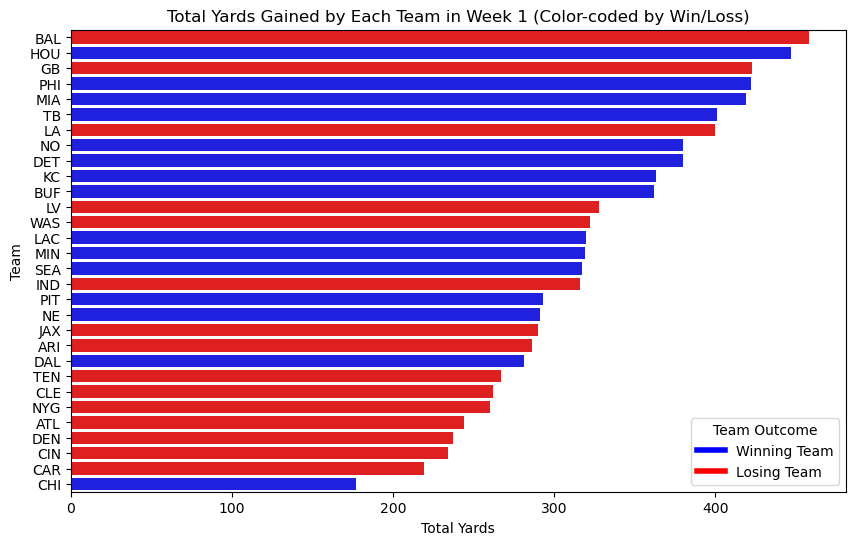

In [28]:
# Visualization: Total yards gained by each team, color-coded by win/loss
plt.figure(figsize=(10, 6))
bars = sns.barplot(x='total_yards', y='posteam', data=yards_per_team, palette=colors)
plt.title('Total Yards Gained by Each Team in Week 1 (Color-coded by Win/Loss)')
plt.xlabel('Total Yards')
plt.ylabel('Team')

# Adding legend manually
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], color='blue', lw=4, label='Winning Team'),
                   Line2D([0], [0], color='red', lw=4, label='Losing Team')]
plt.legend(handles=legend_elements, title="Team Outcome", loc="lower right")

plt.show()

# Save plot as PNG
plt.savefig('images/total_yards_per_team.png')
plt.close()

In [19]:
# Create a column indicating if the team won (1 for win, 0 for loss)
yards_per_team['win'] = yards_per_team['posteam'].apply(lambda team: 1 if team in winning_teams else 0)

# Calculate average yards for winning teams and losing teams
avg_yards_winning = yards_per_team[yards_per_team['win'] == 1]['total_yards'].mean()
avg_yards_losing = yards_per_team[yards_per_team['win'] == 0]['total_yards'].mean()

# Display the results
print(f"Average Yards Gained by Winning Teams: {avg_yards_winning:.2f}")
print(f"Average Yards Gained by Losing Teams: {avg_yards_losing:.2f}")


Average Yards Gained by Winning Teams: 344.80
Average Yards Gained by Losing Teams: 303.07


/opt/anaconda3/envs/dev/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


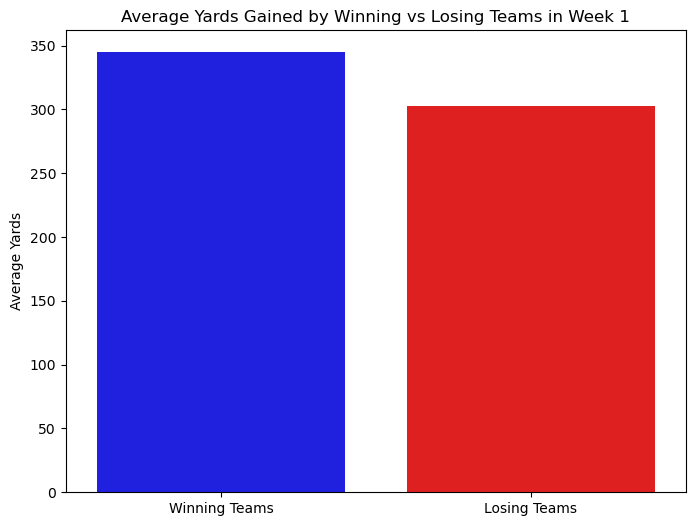

In [29]:
# Visualization: Bar plot to compare average yards gained by winning and losing teams
plt.figure(figsize=(8, 6))
sns.barplot(x=['Winning Teams', 'Losing Teams'], y=[avg_yards_winning, avg_yards_losing], palette=['blue', 'red'])
plt.title('Average Yards Gained by Winning vs Losing Teams in Week 1')
plt.ylabel('Average Yards')

plt.show()

# Save plot as PNG
plt.savefig('images/avg_yards_winning_vs_losing.png')
plt.close()

In [30]:
# Fill NaN values in the 'penalty' column with 0 to ensure accurate summing
df['penalty'] = df['penalty'].fillna(0)

# Group by the team with possession (posteam) and calculate total penalties
penalties_per_team = df.groupby('posteam')['penalty'].sum().reset_index()

# Sort the teams by total penalties, from highest to lowest
penalties_per_team = penalties_per_team.sort_values('penalty', ascending=False)

# Display the total penalties by each team
print("Total penalties committed by each team in Week 1 (sorted by highest to lowest):")
print(penalties_per_team)

Total penalties committed by each team in Week 1 (sorted by highest to lowest):
   posteam  penalty
7      CLE     13.0
11      GB     12.0
3      BUF     12.0
26     SEA     11.0
19     MIA      9.0
8      DAL      9.0
22      NO      9.0
20     MIN      8.0
1      ATL      8.0
14     JAX      8.0
23     NYG      8.0
27      TB      8.0
5      CHI      8.0
12     HOU      7.0
28     TEN      7.0
16      LA      7.0
4      CAR      7.0
15      KC      7.0
25     PIT      6.0
17     LAC      6.0
2      BAL      6.0
24     PHI      5.0
29     WAS      5.0
10     DET      5.0
6      CIN      4.0
21      NE      3.0
18      LV      3.0
9      DEN      3.0
13     IND      2.0
0      ARI      2.0


In [31]:
# Fill NaN values in the 'penalty' column with 0 to ensure accurate summing
df['penalty'] = df['penalty'].fillna(0)

# Group by the team with possession (posteam) and calculate total penalties
penalties_per_team = df.groupby('posteam')['penalty'].sum().reset_index()

# List of teams that won (using team abbreviations)
winning_teams = ['KC', 'PHI', 'LAC', 'BUF', 'NE', 'MIN', 'CHI', 'NO', 'PIT', 'MIA', 'HOU', 'SEA', 'DAL', 'TB', 'DET']

# Create a column indicating if the team won (1 for win, 0 for loss)
penalties_per_team['win'] = penalties_per_team['posteam'].apply(lambda team: 1 if team in winning_teams else 0)

# Calculate average penalties for winning teams and losing teams
avg_penalties_winning = penalties_per_team[penalties_per_team['win'] == 1]['penalty'].mean()
avg_penalties_losing = penalties_per_team[penalties_per_team['win'] == 0]['penalty'].mean()

# Display the results
print(f"Average Penalties for Winning Teams: {avg_penalties_winning:.2f}")
print(f"Average Penalties for Losing Teams: {avg_penalties_losing:.2f}")

Average Penalties for Winning Teams: 7.53
Average Penalties for Losing Teams: 6.33


/opt/anaconda3/envs/dev/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


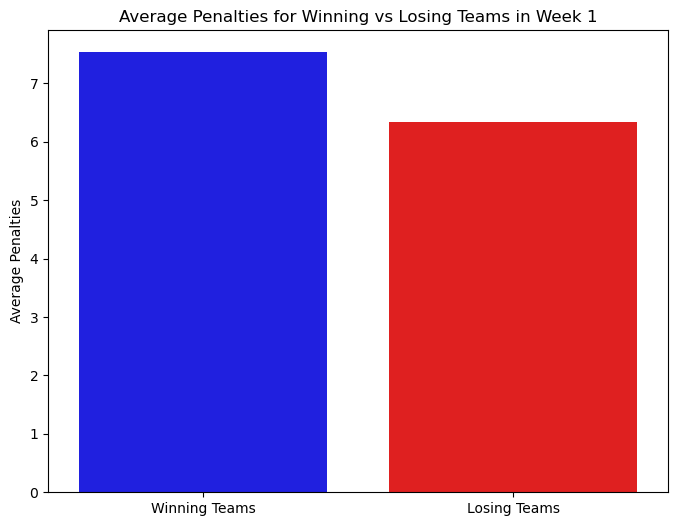

In [32]:
# Visualization: Bar plot to compare average penalties for winning and losing teams
plt.figure(figsize=(8, 6))
sns.barplot(x=['Winning Teams', 'Losing Teams'], y=[avg_penalties_winning, avg_penalties_losing], palette=['blue', 'red'])
plt.title('Average Penalties for Winning vs Losing Teams in Week 1')
plt.ylabel('Average Penalties')

plt.show()

# Save plot as PNG
plt.savefig('images/avg_penalties_winning_vs_losing.png')
plt.close()


In [33]:
# Count turnovers from 'fixed_drive_result' where the value is 'Turnover',
# ensuring no duplicates by checking 'drive_time_of_possession'
df['turnover'] = df.apply(
    lambda row: 1 if row['fixed_drive_result'] == 'Turnover' else 0, axis=1
)

# Remove duplicate turnovers within the same team and drive time
df_turnover_deduped = df.drop_duplicates(subset=['posteam', 'drive_time_of_possession', 'fixed_drive_result'])

# Group by the team with possession (posteam) and calculate turnovers without duplicates
turnovers = df_turnover_deduped.groupby('posteam')['turnover'].sum().reset_index()

# Now calculate touchdowns and field goals without deduplicating
touchdowns = df.groupby('posteam')['touchdown'].sum().reset_index()
field_goals = df.groupby('posteam')['field_goal_attempt'].sum().reset_index()

# Merge the results to get the complete team stats
team_stats = touchdowns.merge(field_goals, on='posteam').merge(turnovers, on='posteam')

# Rename columns for clarity
team_stats.columns = ['Team', 'Total Touchdowns', 'Total Field Goals', 'Total Turnovers']

# Display the resulting DataFrame
team_stats

,Team,Total Touchdowns,Total Field Goals,Total Turnovers
0,ARI,3.0,2.0,1
1,ATL,1.0,1.0,3
2,BAL,2.0,3.0,1
3,BUF,4.0,2.0,1
4,CAR,1.0,1.0,3
5,CHI,0.0,3.0,0
6,CIN,1.0,1.0,1
7,CLE,3.0,1.0,2
8,DAL,2.0,4.0,0
9,DEN,1.0,3.0,3


In [34]:
# List of teams that won (using team abbreviations)
winning_teams = ['KC', 'PHI', 'LAC', 'BUF', 'NE', 'MIN', 'CHI', 'NO', 'PIT', 'MIA', 'HOU', 'SEA', 'DAL', 'TB', 'DET']

# Count turnovers from 'fixed_drive_result' where the value is 'Turnover'
df['turnover'] = df.apply(
    lambda row: 1 if row['fixed_drive_result'] == 'Turnover' else 0, axis=1
)

# Remove duplicate turnovers within the same team and drive time
df_turnover_deduped = df.drop_duplicates(subset=['posteam', 'drive_time_of_possession', 'fixed_drive_result'])

# Group by the team with possession (posteam) and calculate total turnovers
turnovers_per_team = df_turnover_deduped.groupby('posteam')['turnover'].sum().reset_index()

# Add a column indicating if the team won (1 for win, 0 for loss)
turnovers_per_team['win'] = turnovers_per_team['posteam'].apply(lambda team: 1 if team in winning_teams else 0)

# Calculate average turnovers for winning teams and losing teams
avg_turnovers_winning = turnovers_per_team[turnovers_per_team['win'] == 1]['turnover'].mean()
avg_turnovers_losing = turnovers_per_team[turnovers_per_team['win'] == 0]['turnover'].mean()

# Display the results
print(f"Average Turnovers for Winning Teams: {avg_turnovers_winning:.2f}")
print(f"Average Turnovers for Losing Teams: {avg_turnovers_losing:.2f}")


Average Turnovers for Winning Teams: 0.60
Average Turnovers for Losing Teams: 1.60


/opt/anaconda3/envs/dev/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


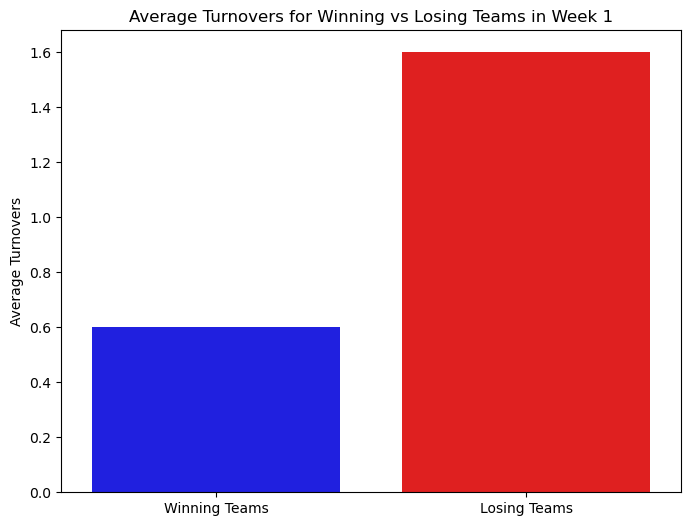

In [35]:
# Visualization: Bar plot to compare average turnovers for winning and losing teams
plt.figure(figsize=(8, 6))
sns.barplot(x=['Winning Teams', 'Losing Teams'], y=[avg_turnovers_winning, avg_turnovers_losing], palette=['blue', 'red'])
plt.title('Average Turnovers for Winning vs Losing Teams in Week 1')
plt.ylabel('Average Turnovers')


plt.show()

# Save plot as PNG
plt.savefig('images/avg_turnovers_winning_vs_losing.png')
plt.close()


### Question #4
---
**Darell Johnson**

- What are the conversion rates for possession downs? What tendencies did you identify?